In [206]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score

In [207]:
# Define a function to generate a shareable link from a Google Drive file ID
def gd_path(file_id):
    return f"https://drive.google.com/uc?export=download&id={file_id}"

# Define file IDs for different datasets and an ID for the project
files_id = {
    'mush_data': "1ErjUx-K9Az--O73ji-rwVPsmg0H9JFR6",      # Mushroom training data
    'test_mush_data': "1DflyaLjlyxNoebKHOSBqB0GkPe1z7qaf", # Test data for mushrooms
    'ids_com': "1CsRSHVvnecwpTteh6kkKjwkqp3pThIHh"        # ID for the project
}

# Read the mushroom training data from Google Drive using the file ID
mush_data = pd.read_csv(gd_path(files_id['mush_data']), sep=",")

# Read the test data for mushrooms from Google Drive using the file ID
test_mush_data = pd.read_csv(gd_path(files_id['test_mush_data']), sep=",")

# Read the ID data for the project from Google Drive using the file ID
ids_com = pd.read_csv(gd_path(files_id['ids_com']), sep=",")

# Assign the mushroom training data to the DataFrame 'df'
df = mush_data

# Pre-Processing Pipe

In [208]:
# X and y creation
y = df.pop("poisonous")

# Feature Engineering
X = df.drop('Id', axis=1)

# data splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [209]:
# building the pipeline
X_cat = X.select_dtypes(exclude="number").copy()
X_num = X.select_dtypes(include="number").copy()

#  numerical pipeline
numeric_pipe = make_pipeline(
    SimpleImputer(strategy="mean"))

onehot_cols = X_cat.columns.get_indexer(['cap.shape', 'cap.color', 'bruises', 'stalk.color.above.ring',
       'stalk.color.below.ring', 'population'])

categorical_encoder = ColumnTransformer(
    transformers=[
        ("cat_onehot", OneHotEncoder(handle_unknown="ignore"), onehot_cols)
    ]
)

categoric_pipe = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="N_A"),
    categorical_encoder 
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num_pipe", numeric_pipe, X_num.columns),
        ("cat_pipe", categoric_pipe, X_cat.columns),
    ]
)

# Models

## Decisiontree - Creation

In [181]:
from sklearn.model_selection import GridSearchCV

full_pipeline = make_pipeline(preprocessor,
                              DecisionTreeClassifier(class_weight='balanced'))

param_grid = {
    "columntransformer__num_pipe__simpleimputer__strategy":["mean", "median"],
    "decisiontreeclassifier__max_depth": range(2, 14, 2),
    "decisiontreeclassifier__min_samples_leaf": range(3, 12, 2)
}


search = GridSearchCV(full_pipeline,
                      param_grid,
                      cv=5,
                      verbose=1)

search.fit(X_train, y_train)


scores = {"dtree" : search.best_score_}

# After fitting the model
search.best_estimator_.threshold = 0.01  # Adjust the threshold as needed

scores

Fitting 5 folds for each of 60 candidates, totalling 300 fits


{'dtree': 0.9557620122899237}

## Decisiontree - Analysis

In [182]:

# Get predictions for the training and testing datasets
y_train_pred = search.predict(X_train)
y_test_pred = search.predict(X_test)

# Create confusion matrices
confusion_matrix_train = confusion_matrix(y_train, y_train_pred)
confusion_matrix_test = confusion_matrix(y_test, y_test_pred)

# Calculate accuracy for training and testing datasets
accuracy_train = accuracy_score(y_train, y_train_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)

print("Training Accuracy:", round(accuracy_train,3))
print("Testing Accuracy:", round(accuracy_test,3),"\n")

print("Confusion Matrix (Training):\n", confusion_matrix_train,"\n")
print("Confusion Matrix (Testing):\n", confusion_matrix_test,"\n")

print("F-Score:\n")
print("Training Score:", round(f1_score(y_train,y_train_pred),3))
print("Testing Score:", round(f1_score(y_test,y_test_pred),3),"\n")

print("Kappa-Score:\n")
print("Training Score:", round(cohen_kappa_score(y_train,y_train_pred),3))
print("Testing Score:", round(cohen_kappa_score(y_test,y_test_pred),3))

Training Accuracy: 0.957
Testing Accuracy: 0.964 

Confusion Matrix (Training):
 [[2495  176]
 [  45 2483]] 

Confusion Matrix (Testing):
 [[634  37]
 [ 10 619]] 

F-Score:

Training Score: 0.957
Testing Score: 0.963 

Kappa-Score:

Training Score: 0.915
Testing Score: 0.928


In [183]:
import matplotlib.pyplot as plt

def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """

    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

In [223]:
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, cohen_kappa_score

# Define your preprocessing steps in the 'preprocessor' variable
# For example, you can use sklearn's ColumnTransformer and other transformers

full_pipeline = make_pipeline(preprocessor, DecisionTreeClassifier(class_weight='balanced'))

param_grid = {
    "decisiontreeclassifier__max_depth": range(2, 14, 2),
    "decisiontreeclassifier__min_samples_leaf": range(3, 12, 2)
}

search_33 = GridSearchCV(full_pipeline, param_grid, cv=5, verbose=1)
search_33.fit(X_train, y_train)

# Get predictions for the training and testing datasets
y_train_prob = search_33.predict_proba(X_train)[:, 1]  # Probability of being positive
y_test_prob = search_33.predict_proba(X_test)[:, 1]    # Probability of being positive

# Adjust the decision threshold to minimize False Negatives (FN)
threshold = 0.1  # Adjust this threshold as needed
y_train_pred = (y_train_prob > threshold).astype(int)
y_test_pred = (y_test_prob > threshold).astype(int)

# Create confusion matrices
confusion_matrix_train = confusion_matrix(y_train, y_train_pred)
confusion_matrix_test = confusion_matrix(y_test, y_test_pred)

# Calculate accuracy for training and testing datasets
accuracy_train = accuracy_score(y_train, y_train_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)

print("Training Accuracy:", round(accuracy_train, 3))
print("Testing Accuracy:", round(accuracy_test, 3), "\n")

print("Confusion Matrix (Training):\n", confusion_matrix_train, "\n")
print("Confusion Matrix (Testing):\n", confusion_matrix_test, "\n")

print("F-Score:\n")
print("Training Score:", round(f1_score(y_train, y_train_pred), 3))
print("Testing Score:", round(f1_score(y_test, y_test_pred), 3), "\n")

print("Kappa-Score:\n")
print("Training Score:", round(cohen_kappa_score(y_train, y_train_pred), 3))
print("Testing Score:", round(cohen_kappa_score(y_test, y_test_pred), 3))


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Training Accuracy: 0.941
Testing Accuracy: 0.945 

Confusion Matrix (Training):
 [[2366  305]
 [   0 2528]] 

Confusion Matrix (Testing):
 [[600  71]
 [  1 628]] 

F-Score:

Training Score: 0.943
Testing Score: 0.946 

Kappa-Score:

Training Score: 0.883
Testing Score: 0.889


model 1 AUC score: 0.9429052789217521


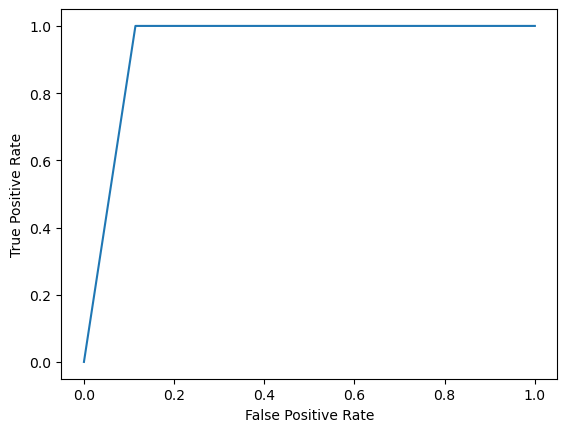

In [211]:
plot_roc_curve(y_train, y_train_pred)
print(f'model 1 AUC score: {roc_auc_score(y_train, y_train_pred)}')

## KNN


In [185]:
# Modeling Pipe - 2

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier


full_pipeline = make_pipeline(preprocessor,
                              KNeighborsClassifier())

param_grid = {
    "columntransformer__num_pipe__simpleimputer__strategy":["mean", "median"],
    "kneighborsclassifier__n_neighbors": range(3, 20, 2)
}

search2 = GridSearchCV(full_pipeline,
                      param_grid,
                      cv=10,
                      verbose=1)

search2.fit(X_train, y_train)

# After fitting the model
search2.best_estimator_.threshold = 0.3  # Adjust the threshold as needed


scores2 = {"knn" : search.best_score_}

scores2


Fitting 10 folds for each of 18 candidates, totalling 180 fits


{'knn': 0.9557620122899237}

## KNN - Analysis

### Confusion Matrix

In [192]:
# Get predictions for the training and testing datasets
y_train_pred = search2.predict(X_train)
y_test_pred = search2.predict(X_test)

# Create confusion matrices
confusion_matrix_train = confusion_matrix(y_train, y_train_pred)
confusion_matrix_test = confusion_matrix(y_test, y_test_pred)

# Calculate accuracy for training and testing datasets
accuracy_train = accuracy_score(y_train, y_train_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)

print("Training Accuracy:", round(accuracy_train,3))
print("Testing Accuracy:", round(accuracy_test,3),"\n")

print("Confusion Matrix (Training):\n", confusion_matrix_train,"\n")
print("Confusion Matrix (Testing):\n", confusion_matrix_test,"\n")

print("F-Score:\n")
print("Training Score:", round(f1_score(y_train,y_train_pred),3))
print("Testing Score:", round(f1_score(y_test,y_test_pred),3),"\n")

print("Kappa-Score:\n")
print("Training Score:", round(cohen_kappa_score(y_train,y_train_pred),3))
print("Testing Score:", round(cohen_kappa_score(y_test,y_test_pred),3))

Training Accuracy: 0.958
Testing Accuracy: 0.965 

Confusion Matrix (Training):
 [[2557  114]
 [ 106 2422]] 

Confusion Matrix (Testing):
 [[649  22]
 [ 24 605]] 

F-Score:

Training Score: 0.957
Testing Score: 0.963 

Kappa-Score:

Training Score: 0.915
Testing Score: 0.929


model 1 AUC score: 0.9581532215450526


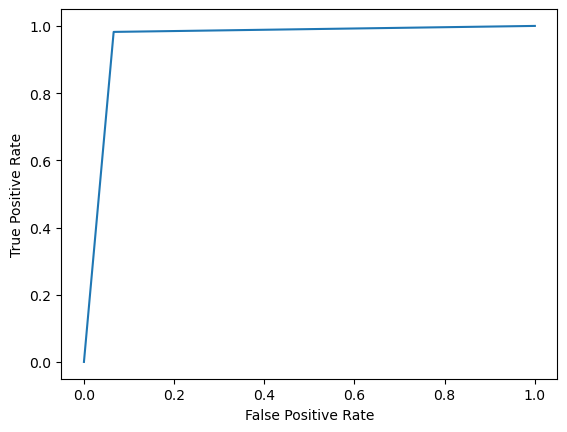

In [187]:
plot_roc_curve(y_train, y_train_pred)
print(f'model 1 AUC score: {roc_auc_score(y_train, y_train_pred)}')

## RandomForest- Creation

In [188]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

full_pipeline = make_pipeline(preprocessor,
                              RandomForestClassifier())

param_grid = {
    "columntransformer__num_pipe__simpleimputer__strategy":["median"],
    "randomforestclassifier__n_estimators": [200, 500],
    'randomforestclassifier__max_depth' : [4,5,6,7,8],
}

# need to be rearange 
search4 = GridSearchCV(full_pipeline,
                      param_grid,
                      cv=5,
                      verbose=1)

search4.fit(X_train, y_train)

# After fitting the model
search4.best_estimator_.threshold = 0.3  # Adjust the threshold as needed


scores4 = {"rf" : search4.best_score_}
print("Best parameters: ", search4.best_params_)
scores4

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters:  {'columntransformer__num_pipe__simpleimputer__strategy': 'median', 'randomforestclassifier__max_depth': 8, 'randomforestclassifier__n_estimators': 500}


{'rf': 0.9436444066039831}

## RandomForest - Analysis

In [189]:
# Get predictions for the training and testing datasets
y_train_pred = search4.predict(X_train)
y_test_pred = search4.predict(X_test)

# Create confusion matrices
confusion_matrix_train = confusion_matrix(y_train, y_train_pred)
confusion_matrix_test = confusion_matrix(y_test, y_test_pred)

# Calculate accuracy for training and testing datasets
accuracy_train = accuracy_score(y_train, y_train_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)

print("Training Accuracy:", round(accuracy_train,3))
print("Testing Accuracy:", round(accuracy_test,3),"\n")

print("Confusion Matrix (Training):\n", confusion_matrix_train,"\n")
print("Confusion Matrix (Testing):\n", confusion_matrix_test,"\n")

print("F-Score:\n")
print("Training Score:", round(f1_score(y_train,y_train_pred),3))
print("Testing Score:", round(f1_score(y_test,y_test_pred),3),"\n")

print("Kappa-Score:\n")
print("Training Score:", round(cohen_kappa_score(y_train,y_train_pred),3))
print("Testing Score:", round(cohen_kappa_score(y_test,y_test_pred),3))

Training Accuracy: 0.945
Testing Accuracy: 0.947 

Confusion Matrix (Training):
 [[2582   89]
 [ 199 2329]] 

Confusion Matrix (Testing):
 [[650  21]
 [ 48 581]] 

F-Score:

Training Score: 0.942
Testing Score: 0.944 

Kappa-Score:

Training Score: 0.889
Testing Score: 0.894


model 1 AUC score: 0.9439803959783706


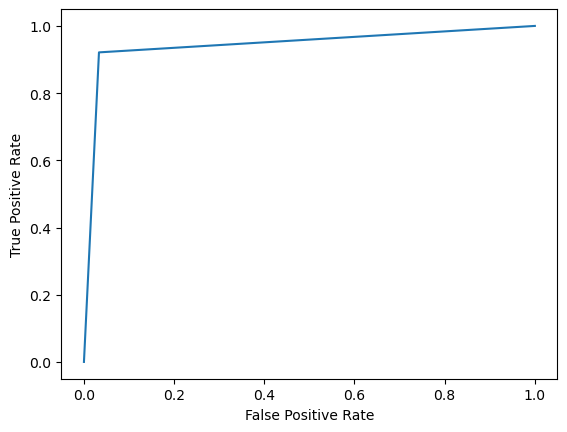

In [190]:
plot_roc_curve(y_train, y_train_pred)
print(f'model 1 AUC score: {roc_auc_score(y_train, y_train_pred)}')

# Downloand

In [216]:
# Define X_sumbmition as the test_mush_data
X_sumbmition = test_mush_data

# Use the trained model (search_33) to predict 'poisonous' for X_sumbmition
ids_com['poisonous'] = search_33.predict(X_sumbmition)

# Save the predictions to a CSV file named 'submission_33.csv'
ids_com.to_csv(r'submission_33.csv', index=False)

## Using an Threshold

In [222]:
# Predict probabilities of being positive using your model (search_33)
y_sumbmition_prob = search_33.predict_proba(X_sumbmition)[:, 1]

# Adjust the threshold to minimize False Negatives (FN)
threshold = 0.01  # You can adjust this threshold as needed to control the trade-off between FN and FP

# Update the 'poisonous' column in ids_com based on the adjusted threshold
ids_com['poisonous'] = (y_sumbmition_prob > threshold).astype(int)

# Save the modified predictions to a CSV file named 'submission_01.csv'
ids_com.to_csv(r'submission_01.csv', index=False)

## Dummy Model

In [224]:
# Define X_sumbmition as the test_mush_data
X_sumbmition = test_mush_data

# Assign a constant value of 1 to the 'poisonous' column in the ids_com DataFrame
ids_com['poisonous'] = 1

# Save the DataFrame with constant values to a CSV file named 'submission_dumm.csv'
ids_com.to_csv(r'submission_dumm.csv', index=False)